In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import opt_einsum as oe
import matplotlib.pyplot as plt
import os

np.set_printoptions(threshold=np.inf, linewidth=np.inf)

from quant_rotor.core.dense.hamiltonian import hamiltonian_dense
from quant_rotor.models.dense.density_matrix import density_matrix_1, density_matrix_2
from quant_rotor.core.dense.hamiltonian_big import hamiltonian_general_dense

from quant_rotor.core.sparse.hamiltonian import hamiltonian_sparse
from quant_rotor.core.sparse.hamiltonian_big import hamiltonian_general_sparse
from quant_rotor.core.dense.hamiltonian_big import hamiltonian_general_dense


from quant_rotor.models.dense.support_ham import write_matrix_elements

# Check dencity matrix 

## Check

In [2]:
site = 3
state = 11
g = 1

In [3]:
HKV = hamiltonian_dense(state, site, g)

H = HKV[0]
V = HKV[2]

In [4]:
H_NO, _, _ = hamiltonian_general_dense(state, site, g)

In [5]:
eig_val, eig_vec = np.linalg.eigh(H)

In [6]:
eig_val_NO, eig_vec_NO = np.linalg.eigh(H_NO)

In [7]:
np.allclose(np.sort(eig_val), np.sort(eig_val_NO), atol=1e-20)

False

## Check 1-d, 2-d eigenvalue ocupation.

In [2]:
site = 4
state = 11
g = 1

In [3]:
H, K, V = hamiltonian_sparse(state, site, g)

/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/scipy/sparse/_sputils.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(obj, dtype=dtype, copy=copy)


In [4]:
_, ground_state_vec_1 = sp.linalg.eigsh(H, k=1, which='SA', tol=1e-19, maxiter=2000)

In [5]:
# eig_val, eig_vec = np.linalg.eigh(H.toarray())

# # Find the index associated with the smallest eigenstate.
# index = np.argmin(eig_val)
# ground_state_vec = eig_vec[:, index]

In [6]:
D_1 = density_matrix_1(state, site, ground_state_vec_1, 0)
D_2 = density_matrix_2(state, site, ground_state_vec_1, 0, 1)

In [7]:
D_2.shape

(11, 11, 11, 11)

In [8]:
eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(state**2, state**2))

In [9]:
-np.sort(-eig_val_D_1)

array([5.87307947e-01, 3.98078463e-01, 1.11393103e-02, 2.28131994e-03, 1.14825818e-03, 3.14753609e-05, 1.30455896e-05, 9.26346392e-08, 8.78621721e-08, 2.07069854e-10, 1.51189553e-10])

In [10]:
-np.sort(-eig_val_D_2)

array([ 5.45490017e-01,  4.38502992e-01,  8.20366419e-03,  2.87768097e-03,  1.70695786e-03,  1.28399343e-03,  1.14552387e-03,  5.03319200e-04,  1.15538680e-04,  7.10777272e-05,  3.46012848e-05,  2.58918157e-05,  1.78182000e-05,  5.00201258e-06,  3.92161216e-06,  3.51267837e-06,  3.04571666e-06,  2.51251528e-06,  1.05107532e-06,  1.00839097e-06,  2.27487629e-07,  2.17957693e-07,  1.53583359e-07,  7.17583621e-08,  6.37342345e-08,  3.11982944e-08,  2.94822025e-08,  2.72643788e-08,  1.32538618e-08,  9.58650930e-09,  9.45313754e-09,  4.76073796e-09,  3.13097585e-09,  2.70533842e-09,  1.28454734e-09,  7.91629490e-10,  7.08789958e-10,  6.45435469e-10,  3.36246112e-10,  2.03456128e-10,  1.79014266e-10,  6.00527166e-11,  4.70601952e-11,  3.52160620e-11,  2.47695487e-11,  1.99266018e-11,  1.94488838e-11,  1.01661459e-11,  9.99329764e-12,  8.22864386e-12,  5.47894722e-12,  2.82179629e-12,  2.35622524e-12,  1.08711277e-12,  1.01570382e-12,  9.49947566e-13,  7.65348035e-13,  4.56149987e-13,  3.7460

In [11]:
index_1 = np.argsort(-eig_val_D_1)
index_2 = np.argsort(-eig_val_D_2)

In [12]:
np.set_printoptions(precision=10, suppress=True)

print(np.round(eig_vec_D_1[:, index_1[:2]].real, 10))

[[-0.977014549   0.          ]
 [-0.           -0.0008764609]
 [ 0.            0.0008764609]
 [ 0.1507259211 -0.          ]
 [ 0.1507259211 -0.          ]
 [ 0.            0.0000319148]
 [ 0.           -0.0000319148]
 [-0.0017269269  0.          ]
 [-0.0017269269  0.          ]
 [-0.           -0.0000001509]
 [-0.            0.0000001509]]


In [13]:
eig_vec_D_1[:, index_1[1]].real + eig_vec_D_1[:, index_1[0]].real

array([-0.977014549 , -0.0008764609,  0.0008764609,  0.1507259211,  0.1507259211,  0.0000319148, -0.0000319148, -0.0017269269, -0.0017269269, -0.0000001509,  0.0000001509])

In [14]:
eig_vec_D_2[:, index_2[:2]].real

array([[-0.7848867284,  0.          ],
       [-0.          , -0.0017557286],
       [ 0.          ,  0.0017557286],
       [ 0.109619935 , -0.          ],
       [ 0.109619935 , -0.          ],
       [ 0.          ,  0.0000581519],
       [-0.          , -0.0000581519],
       [-0.0011347462,  0.          ],
       [-0.0011347462,  0.          ],
       [-0.          , -0.0000002544],
       [-0.          ,  0.0000002544],
       [-0.          , -0.0017557286],
       [ 0.3287690687, -0.          ],
       [-0.2399797444,  0.          ],
       [ 0.          ,  0.0003828264],
       [ 0.          ,  0.0002320016],
       [-0.0143151307,  0.          ],
       [ 0.0074094639, -0.          ],
       [-0.          , -0.0000051769],
       [-0.          , -0.0000024627],
       [ 0.0000725061, -0.          ],
       [-0.0000320601,  0.          ],
       [ 0.          ,  0.0017557286],
       [-0.2399797444,  0.          ],
       [ 0.3287690687, -0.          ],
       [-0.          , -0

In [15]:
np.max(np.abs(eig_vec_D_2[:, index_2[0]].real + eig_vec_D_2[:, index_2[1]].real))

np.float64(0.7848867283556953)

## Plot graph 

In [40]:
def load_one_simulation_ED(sites: int, states: int, g: float, directory: str = ".") -> dict:
    """
    Loads eigenvalues, eigenvectors, and NO basis matrix for a specific (sites, states, g) system.

    Returns a dictionary with 'eigvals', 'eigvecs', and 'NO_basis'.
    """
    g_str = f"{g:.1f}"
    base = f"sites{sites}_states{states}_g{g_str}"

    eigvals_path = os.path.join(directory, f"eigvals_{base}.npy")
    eigvecs_path = os.path.join(directory, f"eigvecs_{base}.npy")

    try:
        eigvals = np.load(eigvals_path)
        eigvecs = np.load(eigvecs_path)

        return eigvals, eigvecs

    except FileNotFoundError as e:
        print(f"[Error] Missing file for (sites={sites}, states={states}, g={g_str}): {e}")
        return None

In [41]:
def load_one_simulation_NO(sites: int, states: int, g: float, directory: str = ".") -> dict:
    """
    Loads eigenvalues, eigenvectors, and NO basis matrix for a specific (sites, states, g) system.

    Returns a dictionary with 'eigvals', 'eigvecs', and 'NO_basis'.
    """
    g_str = f"{g:.1f}"
    base = f"sites{sites}_states{states}_g{g_str}"

    eigvals_path = os.path.join(directory, f"NO_eigvals_{base}.npy")
    eigvecs_path = os.path.join(directory, f"NO_eigvecs_{base}.npy")
    NO_basis_path = os.path.join(directory, f"NO_basis_{base}.npy")

    try:
        eigvals = np.load(eigvals_path)
        eigvecs = np.load(eigvecs_path)
        NO_basis = np.load(NO_basis_path)

        return eigvals, eigvecs, NO_basis

    except FileNotFoundError as e:
        print(f"[Error] Missing file for (sites={sites}, states={states}, g={g_str}): {e}")
        return {}

In [42]:
def scatter_and_fit(g, y, label, color, degree=10, visible_indices=None):
    """
    Plot selected points from (g, y), fit to full data, and draw the fit curve.

    Parameters:
        g, y: full data arrays
        label: label for legend
        color: color for plot
        degree: degree of polynomial fit
        visible_indices: indices of points to show in the scatter plot
    """
    g = np.asarray(g)
    y = np.asarray(y)

    if visible_indices is not None:
        g_visible = g[visible_indices]
        y_visible = y[visible_indices]
    else:
        g_visible = g
        y_visible = y

    # Show only selected data points
    plt.scatter(g_visible, y_visible, label=f"{label}", color=color, s=30)

    # Fit to full data
    coeffs = np.polyfit(g, y, degree)
    poly_fn = np.poly1d(coeffs)

    # Plot fitted polynomial
    g_smooth = np.linspace(g.min(), g.max(), 300)
    y_smooth = poly_fn(g_smooth)
    plt.plot(g_smooth, y_smooth, linestyle='--', color=color)

In [43]:
def scatter_and_fit_4(g, y, label, color, degree=10, visible_indices=None, ax=None):
    """
    Plot selected points from (g, y), fit to full data, and draw the fit curve.

    Parameters
    ----------
    g, y : array-like
        Data arrays.
    label : str
        Label for legend or subplot title.
    color : str
        Color for plot.
    degree : int, optional
        Degree of polynomial fit (default=10).
    visible_indices : array-like, optional
        Indices of points to show in the scatter plot.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on (if None, uses current axis).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if ax is None:
        ax = plt.gca()

    g = np.asarray(g)
    y = np.asarray(y)

    if visible_indices is not None:
        g_visible = g[visible_indices]
        y_visible = y[visible_indices]
    else:
        g_visible = g
        y_visible = y

    # Scatter visible points
    ax.scatter(g_visible, y_visible, label=label, color=color, s=30)

    # Fit to full data
    coeffs = np.polyfit(g, y, degree)
    poly_fn = np.poly1d(coeffs)

    # Plot fitted polynomial
    g_smooth = np.linspace(g.min(), g.max(), 300)
    y_smooth = poly_fn(g_smooth)
    ax.plot(g_smooth, y_smooth, linestyle='--', color=color)

In [44]:
file_path_ED = "./quant_rotor/data/ED_analisis_data"
file_path_ED_s = "./quant_rotor/dataED_analisis_data_sparce"
file_path_T_amplitudes = "./quant_rotor/dataT_amplitudes_energy"

**Plot eingenvalues.**

In [52]:
si3_st11_ED = np.zeros((4, 51))
si3_st5_NO = np.zeros((4, 51))
si5_st5_NO = np.zeros((4, 51))
si7_st3_NO = np.zeros((4, 51))
g_array = np.zeros((51))

In [53]:
for g_index in range(1, 51):
    g = g_index / 10
    g_array[g_index] = g

    eig_val, eig_vec = load_one_simulation_ED(3, 11, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index_array]

    D_1 = density_matrix_1(11, 3, ground_state_vec, 0)
    D_2 = density_matrix_2(11, 3, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(11**2, 11**2))

    indx_1 = np.argsort(-eig_val_D_1)
    indx_2 = np.argsort(-eig_val_D_2)

    si3_st11_ED[0, g_index] = eig_val_D_1[indx_1[0]]
    si3_st11_ED[1, g_index] = eig_val_D_1[indx_1[1]]
    si3_st11_ED[2, g_index] = eig_val_D_2[indx_2[0]]
    si3_st11_ED[3, g_index] = eig_val_D_2[indx_2[1]]



    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index_array]

    D_1 = density_matrix_1(5, 3, ground_state_vec, 0)
    D_2 = density_matrix_2(5, 3, ground_state_vec, 0, 1)

    indx_1 = np.argsort(-eig_val_D_1)
    indx_2 = np.argsort(-eig_val_D_2)

    si3_st5_NO[0, g_index] = eig_val_D_1[indx_1[0]]
    si3_st5_NO[1, g_index] = eig_val_D_1[indx_1[1]]
    si3_st5_NO[2, g_index] = eig_val_D_2[indx_2[0]]
    si3_st5_NO[3, g_index] = eig_val_D_2[indx_2[1]]



    eig_val, eig_vec, _ = load_one_simulation_NO(5, 5, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index_array]

    D_1 = density_matrix_1(5, 5, ground_state_vec, 0)
    D_2 = density_matrix_2(5, 5, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(5**2, 5**2))

    indx_1 = np.argsort(-eig_val_D_1)
    indx_2 = np.argsort(-eig_val_D_2)

    si5_st5_NO[0, g_index] = eig_val_D_1[indx_1[0]]
    si5_st5_NO[1, g_index] = eig_val_D_1[indx_1[1]]
    si5_st5_NO[2, g_index] = eig_val_D_2[indx_2[0]]
    si5_st5_NO[3, g_index] = eig_val_D_2[indx_2[1]]



    eig_val, eig_vec, _ = load_one_simulation_NO(7, 3, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index_array]

    D_1 = density_matrix_1(3, 7, ground_state_vec, 0)
    D_2 = density_matrix_2(3, 7, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(3**2, 3**2))

    indx_1 = np.argsort(-eig_val_D_1)
    indx_2 = np.argsort(-eig_val_D_2)

    si7_st3_NO[0, g_index] = eig_val_D_1[indx_1[0]]
    si7_st3_NO[1, g_index] = eig_val_D_1[indx_1[1]]
    si7_st3_NO[2, g_index] = eig_val_D_2[indx_2[0]]
    si7_st3_NO[3, g_index] = eig_val_D_2[indx_2[1]]

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


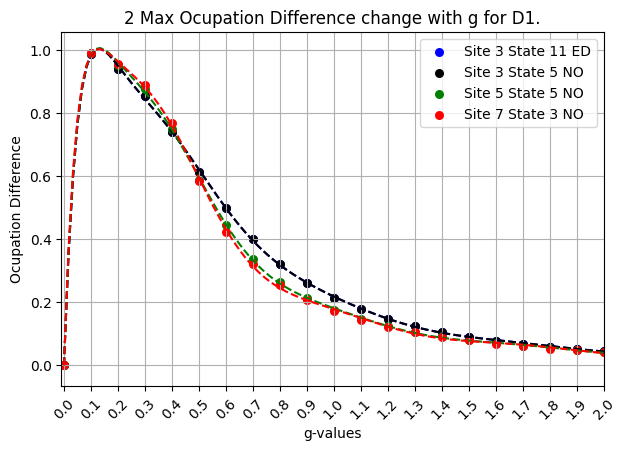

In [ ]:
dim_fit = 20

plt.figure(figsize=(7,4.6))

for y_data, label, color in zip(
    [si3_st11_ED[0, :], si3_st5_NO[0, :], si5_st5_NO[0, :], si7_st3_NO[0, :]],
    [ 'Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'black', 'green', 'red']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)

# Axis formatting
plt.xlim(-0.01,  g_array[g_array <= 2].max())  # show up to g=20
plt.xticks(g_array[g_array <= 2], rotation=45)
plt.xlabel("g-values")
plt.ylabel("Ocupation Difference")
plt.title("2 Max Ocupation Difference change with g for D1.")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


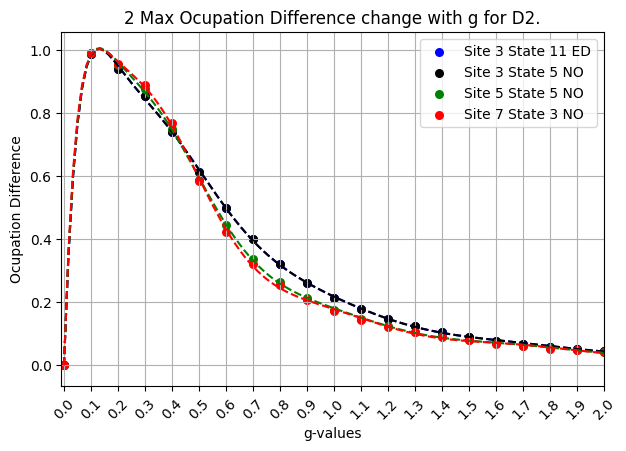

In [ ]:
dim_fit = 20

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(7,4.6))

for y_data, label, color in zip(
    [si3_st11_ED[0, :], si3_st5_NO[0, :], si5_st5_NO[0, :], si7_st3_NO[0, :]],
    [ 'Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'black', 'green', 'red']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)

# Axis formatting
plt.xlim(-0.01,  g_array[g_array <= 2].max())  # show up to g=20
plt.xticks(g_array[g_array <= 2], rotation=45)
plt.xlabel("g-values")
plt.ylabel("Ocupation Difference")
plt.title("2 Max Ocupation Difference change with g for D2.")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var

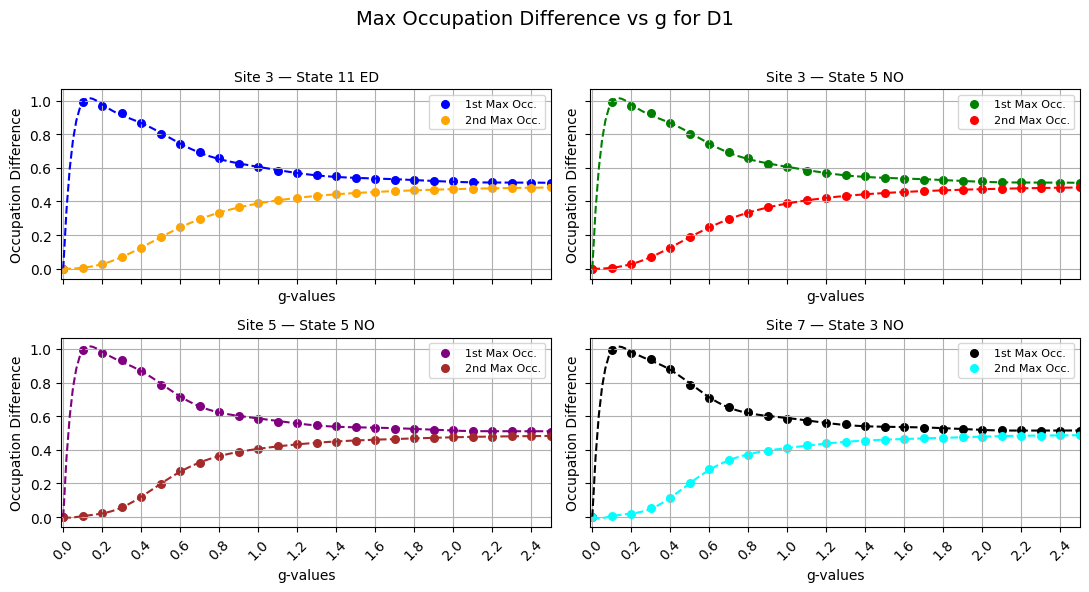

In [58]:
# ---- Two curves per subplot ----
# Each entry = ( [y1, y2], [label1, label2], [color1, color2], graph_title )
datasets = [
    ([si3_st11_ED[0, :], si3_st11_ED[1, :]],
     ['1st Max Occ.', '2nd Max Occ.'],
     ['blue', 'orange'],
     'Site 3 — State 11 ED'),
    ([si3_st5_NO[0, :],  si3_st5_NO[1, :]],
     ['1st Max Occ.', '2nd Max Occ.'],
     ['green', 'red'],
     'Site 3 — State 5 NO'),
    ([si5_st5_NO[0, :],  si5_st5_NO[1, :]],
     ['1st Max Occ.', '2nd Max Occ.'],
     ['purple', 'brown'],
     'Site 5 — State 5 NO'),
    ([si7_st3_NO[0, :],  si7_st3_NO[1, :]],
     ['1st Max Occ.', '2nd Max Occ.'],
     ['black', 'cyan'],
     'Site 7 — State 3 NO')
]

fig, axes = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (y_list, labels, colors, title) in zip(axes, datasets):
    # plot both lines in each subplot
    for y_data, label, color in zip(y_list, labels, colors):
        scatter_and_fit_4(g_array, y_data, label, color, degree=dim_fit, ax=ax)

    ax.set_title(title, fontsize=10)  # 👈 Individual graph name
    ax.grid(True)
    ax.legend(fontsize=8)

# Global axis formatting
for ax in axes:
    ax.set_xlim(-0.01, g_array[g_array <= 2.5].max())
    ax.set_xticks((g_array[g_array <= 2.5])[::2])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("g-values")
    ax.set_ylabel("Occupation Difference")

fig.suptitle("Max Occupation Difference vs g for D1", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_72402/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var

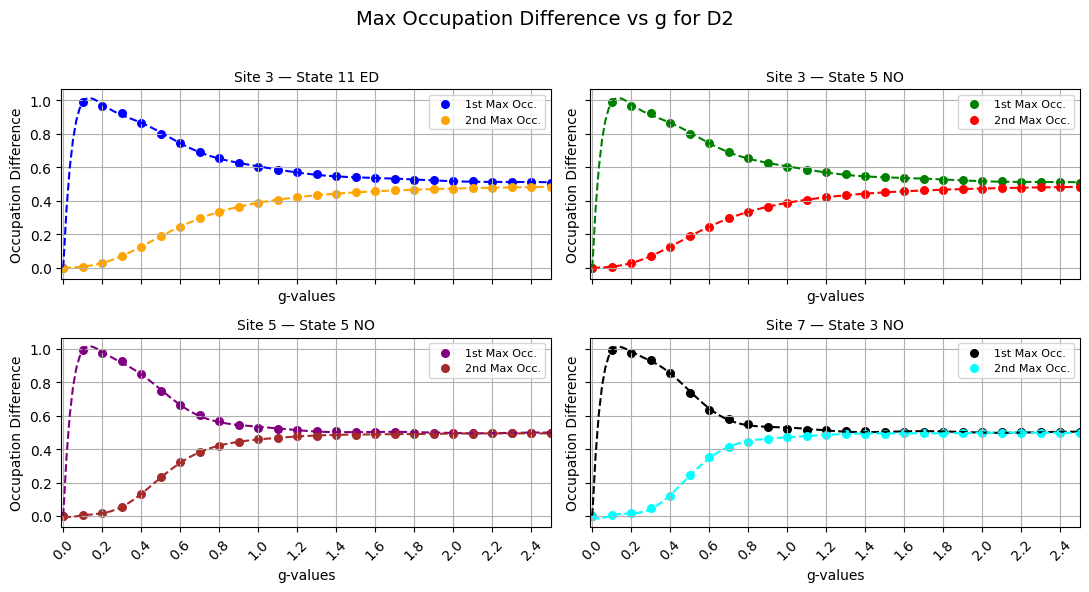

In [56]:
# ---- Two curves per subplot ----
# Each entry = ( [y1, y2], [label1, label2], [color1, color2], graph_title )
datasets = [
    ([si3_st11_ED[2, :], si3_st11_ED[3, :]],
     ['1st Max Occ.', '2nd Max Occ.'],
     ['blue', 'orange'],
     'Site 3 — State 11 ED'),
    ([si3_st5_NO[2, :],  si3_st5_NO[3, :]],
     ['1st Max Occ.', '2nd Max Occ.'],
     ['green', 'red'],
     'Site 3 — State 5 NO'),
    ([si5_st5_NO[2, :],  si5_st5_NO[3, :]],
     ['1st Max Occ.', '2nd Max Occ.'],
     ['purple', 'brown'],
     'Site 5 — State 5 NO'),
    ([si7_st3_NO[2, :],  si7_st3_NO[3, :]],
     ['1st Max Occ.', '2nd Max Occ.'],
     ['black', 'cyan'],
     'Site 7 — State 3 NO')
]

fig, axes = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (y_list, labels, colors, title) in zip(axes, datasets):
    # plot both lines in each subplot
    for y_data, label, color in zip(y_list, labels, colors):
        scatter_and_fit_4(g_array, y_data, label, color, degree=dim_fit, ax=ax)

    ax.set_title(title, fontsize=10)  # 👈 Individual graph name
    ax.grid(True)
    ax.legend(fontsize=8)

# Global axis formatting
for ax in axes:
    ax.set_xlim(-0.01, g_array[g_array <= 2.5].max())
    ax.set_xticks((g_array[g_array <= 2.5])[::2])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("g-values")
    ax.set_ylabel("Occupation Difference")

fig.suptitle("Max Occupation Difference vs g for D2", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

***Plot eigenvectors***

In [45]:
si3_st11_ED_v = np.zeros((2, 51))
si3_st5_NO_v = np.zeros((2, 51))
si5_st5_NO_v = np.zeros((2, 51))
si7_st3_NO_v = np.zeros((2, 51))
g_array_v = np.zeros((51))

In [47]:
for g_index in range(1, 51):
    g = g_index / 10
    g_array_v[g_index] = g

    eig_val, eig_vec = load_one_simulation_ED(3, 11, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index_array]

    D_1 = density_matrix_1(11, 3, ground_state_vec, 0)
    D_2 = density_matrix_2(11, 3, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(11**2, 11**2))

    indx_1 = np.argsort(-eig_val_D_1)
    indx_2 = np.argsort(-eig_val_D_2)

    si3_st11_ED_v[0, g_index] = (np.abs(eig_vec_D_1[indx_1[0]] + eig_vec_D_1[indx_1[1]]))[np.argmax(np.abs(eig_vec_D_1[indx_1[0]] + eig_vec_D_1[indx_1[1]]))]
    si3_st11_ED_v[1, g_index] = (np.abs(eig_vec_D_2[indx_2[0]] + eig_vec_D_2[indx_2[1]]))[np.argmax(np.abs(eig_vec_D_2[indx_2[0]] + eig_vec_D_2[indx_2[1]]))]



    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index_array]

    D_1 = density_matrix_1(5, 3, ground_state_vec, 0)
    D_2 = density_matrix_2(5, 3, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(5**2, 5**2))

    indx_1 = np.argsort(-eig_val_D_1)
    indx_2 = np.argsort(-eig_val_D_2)

    si3_st5_NO_v[0, g_index] = (np.abs(eig_vec_D_1[indx_1[0]] - eig_vec_D_1[indx_1[1]]))[np.argmax(np.abs(eig_vec_D_1[indx_1[0]] - eig_vec_D_1[indx_1[1]]))]
    si3_st5_NO_v[1, g_index] = (np.abs(eig_vec_D_2[indx_2[0]] - eig_vec_D_2[indx_2[1]]))[np.argmax(np.abs(eig_vec_D_2[indx_2[0]] - eig_vec_D_2[indx_2[1]]))]



    eig_val, eig_vec, _ = load_one_simulation_NO(5, 5, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index_array]

    D_1 = density_matrix_1(5, 5, ground_state_vec, 0)
    D_2 = density_matrix_2(5, 5, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(5**2, 5**2))

    indx_1 = np.argsort(-eig_val_D_1)
    indx_2 = np.argsort(-eig_val_D_2)

    si5_st5_NO_v[0, g_index] = (np.abs(eig_vec_D_1[indx_1[0]] - eig_vec_D_1[indx_1[1]]))[np.argmax(np.abs(eig_vec_D_1[indx_1[0]] - eig_vec_D_1[indx_1[1]]))]
    si5_st5_NO_v[1, g_index] = (np.abs(eig_vec_D_2[indx_2[0]] - eig_vec_D_2[indx_2[1]]))[np.argmax(np.abs(eig_vec_D_2[indx_2[0]] - eig_vec_D_2[indx_2[1]]))]



    eig_val, eig_vec, _ = load_one_simulation_NO(7, 3, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index_array]

    D_1 = density_matrix_1(3, 7, ground_state_vec, 0)
    D_2 = density_matrix_2(3, 7, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(3**2, 3**2))

    indx_1 = np.argsort(-eig_val_D_1)
    indx_2 = np.argsort(-eig_val_D_2)

    si7_st3_NO_v[0, g_index] = (np.abs(eig_vec_D_1[indx_1[0]] - eig_vec_D_1[indx_1[1]]))[np.argmax(np.abs(eig_vec_D_1[indx_1[0]] - eig_vec_D_1[indx_1[1]]))]
    si7_st3_NO_v[1, g_index] = (np.abs(eig_vec_D_2[indx_2[0]] - eig_vec_D_2[indx_2[1]]))[np.argmax(np.abs(eig_vec_D_2[indx_2[0]] - eig_vec_D_2[indx_2[1]]))]

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_73720/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_73720/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_73720/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_73720/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


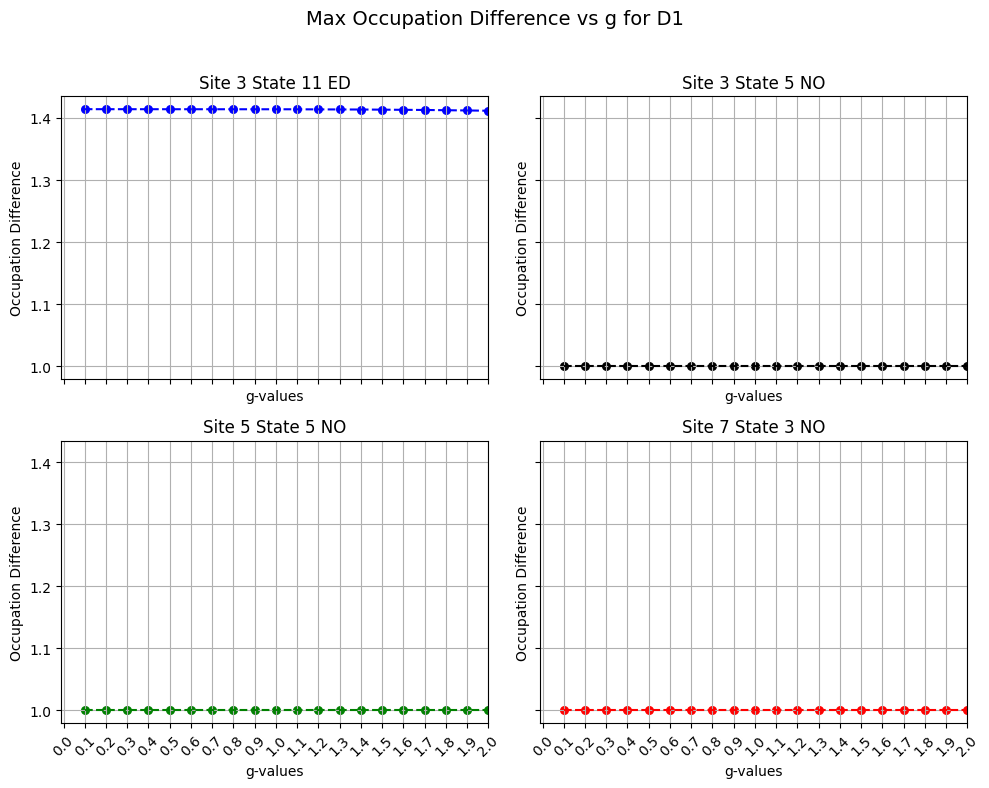

In [51]:
dim_fit = 20
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

# Flatten axes for easy indexing
axes = axes.flatten()

for ax, y_data, label, color in zip(
    axes,
    [si3_st11_ED_v[0, 1:], si3_st5_NO_v[0, 1:], si5_st5_NO_v[0, 1:], si7_st3_NO_v[0, 1:]],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'black', 'green', 'red']
):
    # Scatter and fit each subplot
    scatter_and_fit_4(g_array_v[1:], y_data, label, color, degree=dim_fit, ax=ax)
    ax.set_title(label)
    ax.grid(True)

# Global axis formatting
for ax in axes:
    ax.set_xlim(-0.01, g_array_v[g_array_v <= 2].max())
    ax.set_xticks(g_array_v[g_array_v <= 2])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("g-values")
    ax.set_ylabel("Occupation Difference")

fig.suptitle("Max Occupation Difference vs g for D1", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for the main title
plt.show()

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_73720/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_73720/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_73720/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_73720/2204245572.py:40: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


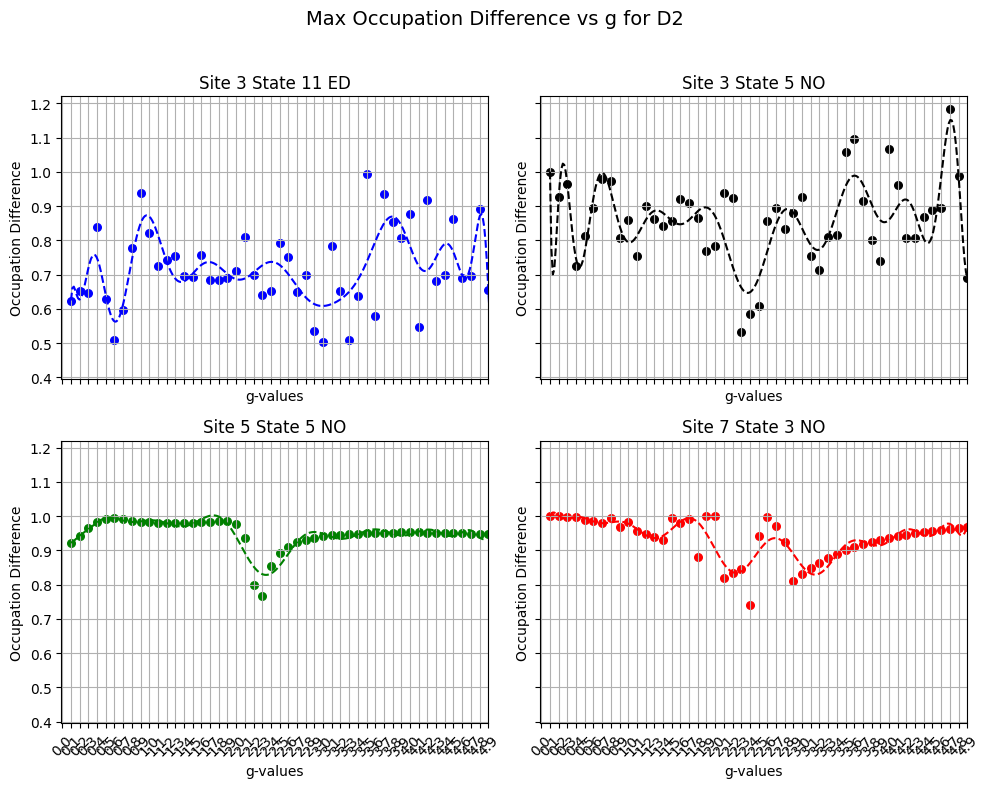

In [53]:
dim_fit = 20
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

# Flatten axes for easy indexing
axes = axes.flatten()

for ax, y_data, label, color in zip(
    axes,
    [si3_st11_ED_v[1, 1:], si3_st5_NO_v[1, 1:], si5_st5_NO_v[1, 1:], si7_st3_NO_v[1, 1:]],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'black', 'green', 'red']
):
    # Scatter and fit each subplot
    scatter_and_fit_4(g_array_v[1:], y_data, label, color, degree=dim_fit, ax=ax)
    ax.set_title(label)
    ax.grid(True)

# Global axis formatting
for ax in axes:
    ax.set_xlim(-0.01, g_array_v[g_array_v <= 4.9].max())
    ax.set_xticks(g_array_v[g_array_v <= 4.9])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("g-values")
    ax.set_ylabel("Occupation Difference")

fig.suptitle("Max Occupation Difference vs g for D2", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for the main title
plt.show()

# Direct diagnilisation

In [ ]:
site = 3
state = 3
g = 1

In [ ]:
H_ED_s, K_ED_s, V_ED_s = hamiltonian_sparse(state, site, g)

H_ED_d = H_ED_s.toarray()
K_ED_d = K_ED_s.toarray()
V_ED_d = V_ED_s.toarray()

eig_val_ED_s, eig_vec_ED_s = np.linalg.eigh(H_ED_d) # produces the solutions to the hamiltonian with energys and associated wavefunctions.

/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/scipy/sparse/_sputils.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(obj, dtype=dtype, copy=copy)


In [ ]:
index = np.argmin(eig_val_ED_s)
ground_energy = eig_val_ED_s[index]

ground_energy

np.float64(-1.8117376914898995)

In [ ]:
# Smallest algebraic eigenpair (ground state)
eigvals, eigvecs = spla.eigsh(H_ED_s, k=1, which='SA', tol=1e-19, maxiter=2000)
E0 = eigvals[0]
psi0 = eigvecs[:, 0]

In [ ]:
# Sanity check: residual
res = sp.linalg.norm(sp.csr_matrix(H_ED_s @ psi0.T - E0 * psi0) / abs(E0 if E0 != 0 else 1))
print(f"E0 = {E0:.12g}, residual = {res:.2e}")

E0 = -1.81173769149, residual = 2.26e-15


In [ ]:
E0 - ground_energy

np.float64(-3.9968028886505635e-15)

In [ ]:
state = 11
site = 3

# for site in range(2, 5):
#     for state in range(5, 11, 2):
for g_index in range(1, 11):
    g = g_index /10
    print(f"{site} Sites, {state} States, g = {g}:")

    H_ED_s, _, _ = hamiltonian_sparse(state, site, g)
    H_ED_d = H_ED_s.toarray()
    eig_val_ED_s, eig_vec_ED_s = np.linalg.eigh(H_ED_d)

    index = np.argmin(eig_val_ED_s)
    E0_ED = eig_val_ED_s[index]

    eig_val_DD, eig_vec_DD = spla.eigsh(H_ED_s, k=1, which='SA', tol=1e-19, maxiter=2000)
    E0_DD = eig_val_DD[0]
    psi0_DD = eig_vec_DD[:, 0]

    res = sp.linalg.norm(sp.csr_matrix(H_ED_s @ psi0_DD - E0_DD * psi0_DD) / abs(E0_DD if E0_DD != 0 else 1))
    print(f"E0 = {E0_DD:.12g}, residual = {res:.2e}")
    print("Compare ground energyes:", np.abs(E0_DD - E0_ED), "\n")


3 Sites, 11 States, g = 0.1:
E0 = -0.0201017290509, residual = 4.48e-12
Compare ground energyes: 8.382183835919932e-15 

3 Sites, 11 States, g = 0.2:
E0 = -0.0858736144732, residual = 1.93e-13
Compare ground energyes: 1.1379786002407855e-15 

3 Sites, 11 States, g = 0.3:
E0 = -0.204382901101, residual = 1.01e-13
Compare ground energyes: 9.381384558082573e-15 

3 Sites, 11 States, g = 0.4:
E0 = -0.378555048775, residual = 5.71e-14
Compare ground energyes: 2.886579864025407e-15 

3 Sites, 11 States, g = 0.5:
E0 = -0.605250827359, residual = 2.65e-14
Compare ground energyes: 6.994405055138486e-15 

3 Sites, 11 States, g = 0.6:
E0 = -0.876710970138, residual = 2.14e-14
Compare ground energyes: 8.659739592076221e-15 

3 Sites, 11 States, g = 0.7:
E0 = -1.18386696572, residual = 1.51e-14
Compare ground energyes: 1.9984014443252818e-15 

3 Sites, 11 States, g = 0.8:
E0 = -1.51872111098, residual = 1.70e-14
Compare ground energyes: 4.884981308350689e-15 

3 Sites, 11 States, g = 0.9:
E0 = -1.8

# Natural Orbitals with direct diagnilisation test.

In [ ]:
state = 3
site = 5
g = 0.6

In [ ]:
H_s, K_s, V_s = hamiltonian_general_sparse(state, site, g)
H_d, K_d, V_d = hamiltonian_general_dense(state, site, g)

In [ ]:
eig_val_NO_s, eig_vec_NO_s = np.linalg.eigh(H_s.toarray())
eig_val_NO_d, eig_vec_NO_d = np.linalg.eigh(H_d)

In [ ]:
np.allclose(eig_val_NO_d, eig_val_NO_s, atol=1e-19)

False